# Demo 2

## Artifically generated encode data

In [20]:
def generate_data(data, bit_rate_step=50, max_bitrate = 8000, min_birate = 50, widths=[1920,1280,  960, 768, 640,  416], heights = [1080,720, 540, 432, 360, 234], col_names=['e_height','e_width', 't_average_bitrate']):
    generated=pd.DataFrame()
    for bitrate in range(min_birate,max_bitrate,bit_rate_step):
        for i in range (len(widths)):
            data[col_names[0]]=heights[i]
            data[col_names[1]]=widths[i]
            data[col_names[2]]=bitrate
            generated = generated.append(data, ignore_index = True)
    return generated

## Highest VMAF value & Getting Encode ladder

In [2]:
def get_data_at_highest_vmaf_per_bps(data):
    best_per_bitrate = pd.DataFrame(columns = data.columns)
    for bitrate in data['t_average_bitrate'].unique():
        df_tmp = data[data['t_average_bitrate']==bitrate]
        best_vmaf = df_tmp[df_tmp['t_average_vmaf']==df_tmp['t_average_vmaf'].max()]
        best_per_bitrate = best_per_bitrate.append(best_vmaf)
    return best_per_bitrate

def get_encoding_latter(best_per_bitrate):
    sorted_df = best_per_bitrate.sort_values('t_average_vmaf')
    jnd_df = pd.DataFrame(sorted_df.head(n=1))
    for i in range(1,len(sorted_df)):
        if not (sorted_df.iloc[i,-1]-jnd_df.iloc[-1,-1])<6:
            jnd_df = jnd_df.append(sorted_df.iloc[i,:], ignore_index = True)
    return jnd_df


# The Best Model - Light GBM

In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
#from data_generation import generate_data
#import finding_resolutions
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

X_train = pd.read_csv('data/training_data/X_train.csv')
X_train.drop('id', axis = 1, inplace=True)
y_train = pd.read_csv('data/training_data/y_train.csv')
y_train.drop('id', axis = 1, inplace=True)
X_test = pd.read_csv('data/test_data/X_test.csv')
X_test.drop('id', axis = 1, inplace=True)
y_test = pd.read_csv('data/test_data/y_test.csv')
y_test.drop('id', axis = 1, inplace=True)

#fill na training data
X_train = X_train.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

#drop variables that worsen prediction
X_train.drop(['s_storage_size', 's_duration'], axis = 1, inplace=True)
X_test.drop(['s_storage_size', 's_duration'], axis = 1, inplace=True)


estimator = lgb.LGBMRegressor()

# this is the way I tested which parametes might be the best ones - in the end I only kept those inside the grid which produced the best results
#I stopped at 9000 estimators because with the improvement with 9000 regarding MSE etc. was too little and R^2 did not improve at all anymore
param_grid = {
    'max_depth': [20],
    'num_leaves': [20],
    'learning_rate': [0.1],
    'n_estimators': [9000]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)
y_pred = gbm.predict(X_test)


# have a look at the results:
print('Mean Absolute Error: %.4f' %
      metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: %.4f' % metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' %
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score:%.4f' % r2_score(y_test, y_pred))

Best parameters found by grid search are: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 9000, 'num_leaves': 20}
Mean Absolute Error: 0.8625
Mean Squared Error: 1.9659
Root Mean Squared Error: 1.4021
R2 score:0.9980


## Artifical "new" movie instance

In [4]:
 data = pd.read_csv('data/data_for_visualization/movie_with_id_12.csv')

#generate the bitrates and resolutions for every step of bps
new_data = generate_data(data.head(n=1))
new_data = new_data[X_train.columns]

#predict 
y_pred_new_data = gbm.predict(new_data)
new_data['t_average_vmaf'] = y_pred_new_data

#get highest vmaf at each resolution 
best_encodings_per_bitrate = get_data_at_highest_vmaf_per_bps(new_data)

#get those with a minimum of 6 vmaf score difference (=1 jnds)
encoding_df = get_encoding_latter(best_encodings_per_bitrate)

#check when (at which bps) to switch resolution and to which resolution
print(encoding_df[['e_width', 'e_height', 't_average_bitrate']])

   e_width e_height t_average_bitrate
0      416      234                50
1      640      360               100
2      640      360               150
3      640      360               200
4      640      360               250
5      640      360               300
6      768      432               400
7      768      432               500
8      768      432               650
9      768      432               850
10     768      432              1150
11     960      540              1650
12    1280      720              2500
13    1280      720              6050


## VISUALIZATION PART

In [5]:
#get the x,y values from the predicted convex hull
x_new=best_encodings_per_bitrate['t_average_bitrate']
y_new=best_encodings_per_bitrate['t_average_vmaf']


all_points =[]
unique_resoultion = data.groupby(['e_width', 'e_height'], as_index = False).size()
unique_resoultion
# fig=plt.figure(figsize=(10,5))
# ax = plt.subplot(111)
# for x in unique_resoultion.index[:]:
#     width,height = x
    
#     x_bitrate = sorted(data['t_average_bitrate'][(data['e_width']==width) & (data['e_height']==height)])
#     y_vmaf = sorted(data['t_average_vmaf'][(data['e_width']==width) & (data['e_height']==height)])
#     for i in range(len(x_bitrate)):
#         all_points.append([x_bitrate[i], y_vmaf[i]])
    
#     ax.plot(x_bitrate, y_vmaf, label = '{} X {}'.format(width,height))

# #plot convex hull of the actual data
# all_points = np.array(all_points)
# hull = ConvexHull(all_points)
# for simplex in hull.simplices:
#     ax.plot(all_points[simplex, 0], all_points[simplex, 1], 'k-')

# #plot predicted convex hull
# ax.plot(x_new,y_new, color = 'fuchsia', label = "predicted convex hall")
# plt.xlabel("Bitrate")
# plt.ylabel("VMAF")
# ax.legend()
# plt.xlim(0,9000)
# plt.show()


e_width  e_height
416      234         14
640      360         13
768      432         13
960      540         13
1280     720         13
1920     1080        12
dtype: int64

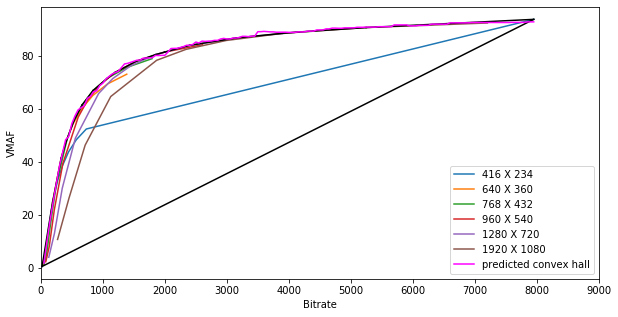

In [6]:
fig=plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for x in unique_resoultion.index[:]:
    width,height = x
    x_bitrate = sorted(data['t_average_bitrate'][(data['e_width']==width) & (data['e_height']==height)])
    y_vmaf = sorted(data['t_average_vmaf'][(data['e_width']==width) & (data['e_height']==height)])
    for i in range(len(x_bitrate)):
        all_points.append([x_bitrate[i], y_vmaf[i]])
    
    ax.plot(x_bitrate, y_vmaf, label = '{} X {}'.format(width,height))

#plot convex hull of the actual data
all_points = np.array(all_points)
hull = ConvexHull(all_points)
for simplex in hull.simplices:
    ax.plot(all_points[simplex, 0], all_points[simplex, 1], 'k-')

#plot predicted convex hull
ax.plot(x_new,y_new, color = 'fuchsia', label = "predicted convex hall")
plt.xlabel("Bitrate")
plt.ylabel("VMAF")
ax.legend()
plt.xlim(0,9000)
plt.show()
